In [127]:
import matplotlib.pyplot as plt
import numpy as np
import torch

from collections import Counter
from scipy import special
from scipy.stats import beta

from conformal_utils import *
from utils.imagenet_helpers import ImageNetHierarchy

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [131]:
# # OPTION 1: Use ImageNet-val
# logits = torch.load('data/imagenet_val/logits.pt')
# labels = torch.load('data/imagenet_val/labels.pt')
# logits = logits.numpy()
# labels = labels.type(torch.LongTensor).numpy()

# OPTION 2: Use ImageNet-train
logits = torch.load('/home/eecs/tiffany_ding/code/SimCLRv2-Pytorch/.cache/logits/imagenet_train_subset_logits.pt', map_location=torch.device('cpu'))
# softmax_scores = torch.load('/home/eecs/tiffany_ding/code/SimCLRv2-Pytorch/.cache/logits/imagenet_train_subset_softmax.pt', map_location=torch.device('cpu'))
labels = torch.load('/home/eecs/tiffany_ding/code/SimCLRv2-Pytorch/.cache/logits/imagenet_train_subset_labels.pt', map_location=torch.device('cpu'))
labels = labels.type(torch.LongTensor).numpy()

In [ ]:
## ONLY HAVE TO RUN THIS ONCE

# Convert logits to softmax vectors (this takes a while)
softmax_scores = special.softmax(logits, axis=1)
torch.save(softmax_scores, 
           '/home/eecs/tiffany_ding/code/SimCLRv2-Pytorch/.cache/logits/imagenet_train_subset_softmax.pt', 
           pickle_protocol=4) # for saving large objects


### Some sanity checks

In [130]:
softmax_scores.shape
# With calib dataset only: (1140240, 1000)

(1140240, 1000)

In [81]:
labels.shape

(1140240,)

In [82]:
min(labels), max(labels)

(0, 999)

In [83]:
# Check the number of instances of each class
Counter(labels)

Counter({728: 945,
         933: 1160,
         601: 1140,
         497: 1165,
         886: 1162,
         757: 1156,
         150: 1156,
         725: 1156,
         344: 1149,
         12: 1155,
         417: 1143,
         66: 1149,
         593: 1170,
         41: 1145,
         352: 1160,
         406: 1147,
         800: 1149,
         698: 1147,
         777: 1155,
         590: 924,
         65: 1150,
         912: 1145,
         499: 966,
         835: 1167,
         2: 1156,
         919: 1154,
         512: 1161,
         379: 1156,
         866: 1166,
         865: 1146,
         913: 1140,
         789: 1107,
         506: 1159,
         673: 1148,
         527: 1177,
         702: 1157,
         75: 1162,
         805: 1161,
         328: 1150,
         899: 1159,
         750: 1168,
         597: 1165,
         875: 1150,
         83: 1185,
         296: 1138,
         47: 1165,
         176: 1158,
         350: 1168,
         625: 1170,
         308: 1151,
         429

# Evaluate baseline methods

Use 5,000 instances as calibration and the remaining 45,000 as validation

1. Perform standard conformal inference and evaluate coverage
2. Perform class-balanced conformal inference and evaluate coverage


In [84]:
alpha = .1

n = len(labels)

scores = 1 - softmax_scores

In [85]:
%%time

np.random.seed(0)

# ======== SHUFFLE DATA ======== 
idx = np.random.permutation(np.arange(len(labels)))
shuffled_scores = scores[idx]
shuffled_labels = labels[idx]

CPU times: user 1.67 s, sys: 2min 22s, total: 2min 23s
Wall time: 2min 25s


In [86]:
%%time
# ======== SPLIT DATA ======== 
num_calib = 50000
calib_scores, calib_labels = shuffled_scores[:num_calib], shuffled_labels[:num_calib]
val_scores, val_labels = shuffled_scores[num_calib:], shuffled_labels[num_calib:]

CPU times: user 0 ns, sys: 443 ms, total: 443 ms
Wall time: 452 ms


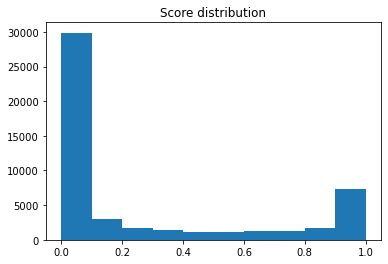

qhat: 0.9718876706671714
Standard conformal inference "marginal coverage": 89.94%


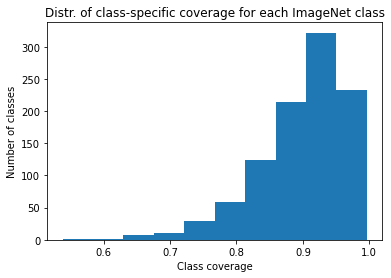

In [87]:
# ======== STANDARD CONFORMAL INFERENCE ======== 
# --- Get confidence sets ---
standard_ci_qhat = compute_qhat(calib_scores, calib_labels, alpha=alpha, plot_scores=True)
print('qhat:', standard_ci_qhat)
standard_ci_preds = create_prediction_sets(val_scores, standard_ci_qhat)

# --- Evaluate confidence sets ---
# i) Marginal coverage
marginal_cov = compute_coverage(val_labels, standard_ci_preds)
print(f'Standard conformal inference "marginal coverage": {marginal_cov*100:.2f}%')
# ii) Class-specific coverage
class_specific_cov = compute_class_specific_coverage(val_labels, standard_ci_preds)
# # print(f'Standard conformal inference "class specific coverage": {class_specific_cov}')
# plt.hist(class_specific_cov)
# plt.xlabel('Class coverage')
# plt.ylabel('Number of classes')
# plt.title('Distr. of class-specific coverage for each ImageNet class')
# plt.show()

<!-- One problem I am running into is that some classes do not appear in the calibration dataset or appear only a few times, which makes $\frac{\lceil(n+1)(1-\alpha)\rceil}{n} \geq 1$, which is not a valid quantile! I'm not sure what is the best approach for dealing with those classes. One option is to just use the non-class-specific quantile obtained from standard conformal inference (practically, this works okay, but there is no theoretical guarantee). Another option is to set the quantile to $\infty$ (this is theoretically sound). -->

Class-balanced conformal inference "marginal coverage": 91.10%


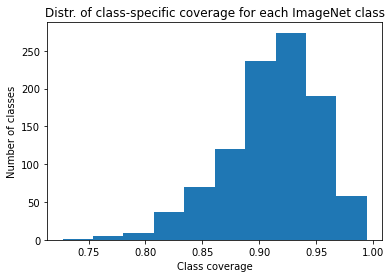

In [88]:
# ======== CLASS-BALANCED CONFORMAL INFERENCE ======== 
# --- Get confidence sets ---
default_qhat = np.inf
qhats = compute_class_specific_qhats(calib_scores, calib_labels, alpha=alpha, default_qhat=default_qhat)
# print('qhats:', qhats)
class_balanced_ci_preds = create_cb_prediction_sets(val_scores, qhats)

# --- Evaluate confidence sets ---
# i) Marginal coverage
cb_marginal_cov = compute_coverage(val_labels, class_balanced_ci_preds)
print(f'Class-balanced conformal inference "marginal coverage": {cb_marginal_cov*100:.2f}%')
# ii) Class-specific coverage
cb_class_specific_cov = compute_class_specific_coverage(val_labels, class_balanced_ci_preds)
# # print(f'Standard conformal inference "class specific coverage": {class_specific_cov}')
# plt.hist(cb_class_specific_cov)
# plt.xlabel('Class coverage')
# plt.ylabel('Number of classes')
# plt.title('Distr. of class-specific coverage for each ImageNet class')
# plt.show()

The analytical distribution of class-specific coverage is $$\frac{1}{K}\sum_{k=1}^K \mathsf{Beta}(\lceil(n_k+1)(1-\alpha)\rceil, n_k + 1 - \lceil(n_k+1)(1-\alpha)\rceil)$$
where $K$ is the total number of classes and $n_k$ is the number of times class $k$ appears in the calibration dataset.

In [123]:
# Get analytical distribution of true class coverages 
def get_analytical_class_cvg_distr(labels, alpha, grid=np.linspace(0, 1, 500)):
    
    # Count the number of instances of each class 
    class_cts = Counter(labels)
    class_cts = [class_cts[i] for i in range(len(class_cts))]

    distr = np.zeros(grid.shape)
    for k in range(len(class_cts)):
        a = np.ceil((class_cts[k] + 1) * (1 - alpha))
        b = class_cts[k] + 1 - a
        distr += beta.pdf(grid, a, b)
        
    distr /= len(class_cts)
    
    return distr

grid = np.linspace(0, 1, 500)
analytical_class_specific_cov_distr = get_analytical_class_cvg_distr(calib_labels, alpha, grid=grid)
# plt.plot(grid, analytical_class_specific_cov_distr)

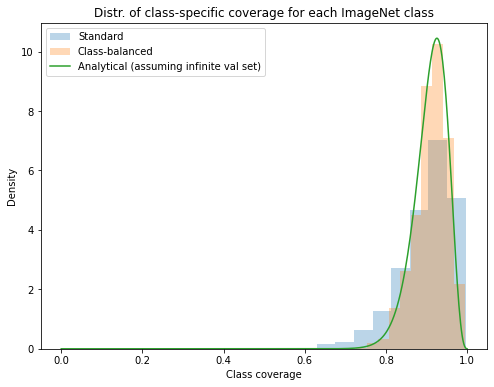

In [124]:
## Plot
plt.figure(figsize=(8,6))

# Combine histograms into one plot
plt.hist(class_specific_cov, label="Standard", alpha=.3, density=True)
plt.hist(cb_class_specific_cov, label="Class-balanced", alpha=.3, density=True)

# # Plot analytical distribution if we assume we have an infinite amount of validation data
plt.plot(grid, analytical_class_specific_cov_distr, label='Analytical (assuming infinite val set)')

# Label plot
plt.xlabel('Class coverage')
plt.ylabel('Density')
plt.title('Distr. of class-specific coverage for each ImageNet class')
plt.legend(loc='upper left')
plt.show()

In [95]:
np.mean(class_specific_cov), np.std(class_specific_cov)

(0.8988885891470894, 0.06705664642773437)

In [96]:
np.mean(cb_class_specific_cov), np.std(cb_class_specific_cov)

(0.9110478328824588, 0.04111764839126961)

In [121]:
# class_balanced_ci_preds

In [122]:
# standard_ci_preds

# Save output

We now create an 1000 x 2 array where row i = [# of times class i appears in validation set, # of times class i is included to conformal set prediction when class i is true label]. Note that the second element is equal to (# of times class i appears in validation set)*(observed class coverage under standard conformal inference).

This array will be fed into the `deconvolveR` package to estimate the distribution of class coverage under standard conformal inference

In [17]:
# # Count the number of instances of each class in the validation set
# class_cts = Counter(val_labels)

# # Create array
# X = np.zeros((1000,2))
# for i in range(len(X)):
#     X[i,:] = [class_cts[i], class_cts[i]*cb_class_specific_cov[i]]
    
# # Save array
# save_to = "data/standard_conformal_class_coverage.csv"
# np.savetxt(save_to, X, delimiter=",")
# print(f'Saved array to {save_to}')

Saved array to data/standard_conformal_class_coverage.csv


Save the cutoffs (quantiles) for each class, as well as the class-specific coverages. This is used to create the json file that I use to create https://observablehq.com/d/5bb27b3940f0bc23

In [61]:
save_to = '/home/eecs/tiffany_ding/code/empirical-bayes-conformal/data/class_balanced_qhats_INtrain.npy'
np.save(save_to, qhats)
print(f'Saved array of qhats to {save_to}')

Saved array of qhats to /home/eecs/tiffany_ding/code/empirical-bayes-conformal/data/class_balanced_qhats_INtrain.npy


In [65]:
save_to = '/home/eecs/tiffany_ding/code/empirical-bayes-conformal/data/class_specific_coverages_INtrain.npy'
np.save(save_to, cb_class_specific_cov)
print(f'Saved class-specific coverages to {save_to}')

Saved class-specific coverages to /home/eecs/tiffany_ding/code/empirical-bayes-conformal/data/class_specific_coverages_INtrain.npy


## Do semantically similar classes have similar qhats? 

Method for computing graph distance:https://www.quora.com/Whatll-be-the-best-method-to-find-the-distances-between-every-two-nodes-in-a-node-tree
```
Now given any two nodes A and B, we can find their deepest common ancestor with the following algorithm:

If the depth of A is greater than the depth of B, find the common ancestor of parent(A) and B.
Otherwise if the depth of B is greater than the depth of A, find the common ancestor of A and parent(B).
Otherwise, if A and B are the same node, then A is the deepest common ancestor.
Otherwise, find the common ancestor of parent(A) and parent(B).
Once you have the deepest common ancestor, C, the distance between A and B is:

depth(A) + depth(B) - 2* depth(C)
```

In [68]:
hier_info_path = 'data/imagenet_hierarchy/'
in_hier = ImageNetHierarchy(hier_info_path)

accordion, piano accordion, squeeze box has multiple parents: ['keyboard instrument', 'free-reed instrument']
bakery, bakeshop, bakehouse has multiple parents: ['shop, store', 'workplace, work']
baseball has multiple parents: ['baseball equipment', 'ball']
basketball has multiple parents: ['basketball equipment', 'ball']
bath towel has multiple parents: ['towel', 'bath linen']
brassiere, bra, bandeau has multiple parents: ['undergarment, unmentionable', "woman's clothing"]
bulletproof vest has multiple parents: ['vest, waistcoat', 'body armor, body armour, suit of armor, suit of armour, coat of mail, cataphract']
computer keyboard, keypad has multiple parents: ['keyboard', 'data input device, input device']
croquet ball has multiple parents: ['ball', 'croquet equipment']
face powder has multiple parents: ['makeup, make-up, war paint', 'powder']
golf ball has multiple parents: ['golf equipment', 'ball']
golfcart, golf cart has multiple parents: ['motor vehicle, automotive vehicle', 'gol

In [91]:
# Test code for computing depths

# def print_depths(curr_node):
#     '''
#     Prints depths of children of current node
#     '''
#     print([f'{c.name}: {c.depth}' for c in curr_node.children])
# #     print([f'{c.depth}' for c in curr_node.children])
#     for c in curr_node.children:
#         print('c', c)
#         print_depths(c)

# root_node = in_hier.get_node("n00001740") 
# print_depths(root_node)

Each list corresponds to the depths of the children of a given node, so we expect the numbers to all be the same. This is generally true, but there are a few weird cases where this is not true. This is possibly because some nodes appear multiple times in ImageNet? Not sure. But I think it not worth spending a lot of time debugging this currently since my code seems operational for the most part. 

In [ ]:
# in_hier.get_node("n00001740").children

In [69]:
# Sanity checks

node1 = in_hier.get_node("n03814906") # necklace
node2 = in_hier.get_node("n04458633") # totem pole
node3 = in_hier.get_node("n07742313") # Granny Smith
node4 = in_hier.get_node("n07745940") # strawberry

in_hier.get_deepest_common_ancestor(node3, node4)

Name: (edible fruit), ImageNet Class: (-1), Descendants: (9)

In [70]:
print(in_hier.compute_distance(node1, node1)) # Expected answer: 0
print(in_hier.compute_distance(node1, node2)) # Expected answer: 6
print(in_hier.compute_distance(node3, node4)) # Expected answer: 5

0
5
5


### Results

In [71]:
%%time 

# 1. For all leaf nodes, compute graph distance and difference between qhats. Then calculate correlation

leaf_nodes = [node for node in in_hier.tree if in_hier.get_node(node).descendant_count_in == 0]

all_combinations = sum([[(n1, n2) for n1 in leaf_nodes] for n2 in leaf_nodes], [])
all_combinations = [(n1, n2) for n1, n2 in all_combinations if n1 != n2] # Filter out n1 == n2

dists = [in_hier.compute_distance(in_hier.get_node(n1), in_hier.get_node(n2)) for n1, n2 in all_combinations]
qhat_diffs = [abs(qhats[in_hier.get_node(n1).class_num] - qhats[in_hier.get_node(n2).class_num])
              for n1, n2 in all_combinations]

CPU times: user 54.9 s, sys: 762 ms, total: 55.7 s
Wall time: 55.6 s


In [73]:
dists = np.array(dists)
qhat_diffs = np.array(qhat_diffs)

np.corrcoef(dists, qhat_diffs)

# For ImageNet val:
# array([[1.        , 0.04959895],
#        [0.04959895, 1.        ]])

array([[1.        , 0.06338782],
       [0.06338782, 1.        ]])

In [74]:
# 2. Compare qhat differences between siblings (distance == 2) vs. between other between non-sibling nodes

sibling_idx = [idx for idx in range(len(dists)) if dists[idx] == 2]

sib_diffs = qhat_diffs[sibling_idx]
nonsib_diffs = qhat_diffs[[idx for idx in range(len(dists)) if idx not in sibling_idx]]

In [75]:
n = len(sib_diffs)
print(f'Mean qhat difference for sibling nodes: {np.mean(sib_diffs):.3f} (std dev: {np.std(sib_diffs) / np.sqrt(n):.3f})')
print(f'Mean qhat difference for non-sibling nodes: {np.mean(nonsib_diffs):.3f} (std dev: {np.std(nonsib_diffs) / np.sqrt(n):.3f})')

# # For ImageNet val:
# Mean qhat difference for sibling nodes: 0.217 (std dev: 0.005)
# Mean qhat difference for non-sibling nodes: 0.245 (std dev: 0.006)

Mean qhat difference for sibling nodes: 0.156 (std dev: 0.005)
Mean qhat difference for non-sibling nodes: 0.231 (std dev: 0.006)


**Conclusion**: Semantically similar classes do not seem to have qhat values that are close to each other